In [1]:
import networkx as nx
import dwave_networkx as dnx
import random
import matplotlib.pyplot as plt
import pulp
import numpy as np

from itertools import permutations
from lpSolver import solve
from uccgGenerator import tree_insertion, Graph
from plotNetwork import plotGraph, plotCoupling, plotGraphIS, plotSymmetricDiff
from networkx.algorithms.chordal import chordal_graph_cliques
from networkx.algorithms.approximation import treewidth_min_fill_in, maximum_independent_set

In [2]:
def valid(g):
    for u, v in g.edges:
        if g.nodes[u]['in'] and g.nodes[v]['in']:
            return False
    return True

def size_is(g):
    return len([u for u in g if g.nodes[u]['in']])

def is_same(g1, g2):
    for u in g1:
        if g1.nodes[u]['in'] !=  g2.nodes[u]['in']:
            return False
    return True

In [3]:
def get_children_add_remove(g, lambd=1):
    total = 0
    children = []
    n = len(g)
    can_remove = [u for u in g.nodes if g.nodes[u]['in']]
    for u in can_remove:
        can_add = []
        for v in g:
            if g.nodes[v]['in']:
                continue
            valid = True
            for w in g.neighbors(v):
                if g.nodes[w]['in'] and w != u:
                    valid = False
            if not valid:
                continue
            cg = Graph(g)
            cg.nodes[u]['in'] = False
            cg.nodes[v]['in'] = True
            cg.move = f"add {v} remove {u}"
            children.append(cg)
    g_stay = Graph(g)
    g_stay.prob = 1 - total
    g_stay.move = 'stay'
    children.append(g_stay)
    return children  

In [4]:
def generate_is_clique_tree(g, rt):
    in_vertices = {u for u in g if g.nodes[u]['in']}
    mapping = {}
    is_rt = nx.DiGraph(rt)
    for node in is_rt:
        common = node.intersection(in_vertices)
        assert len(common) <= 1
        mapping[node] = list(common)[0] if len(common) == 1 else node
    is_rt = nx.relabel_nodes(is_rt, mapping)
    print(len(mapping))
    print(len(is_rt.nodes))
    assert len(mapping) == len(is_rt)
    assert len(is_rt) == len(rt)
    return is_rt

In [5]:
def helper(dt, u):
    if dt.out_degree(u) == 0:
        dt.nodes[u]['in'] = True
        return
    has_in_child = False
    for v in dt.successors(u):
        helper(dt, v)
        if dt.nodes[v]['in']:
            has_in_child = True
    if not has_in_child:
        dt.nodes[u]['in'] = True

In [6]:
def construct_mis(t):
    r = random.sample(t.nodes, 1)[0]
    dt = nx.bfs_tree(t, r)
    for u in dt:
        dt.nodes[u]['in'] = False
    helper(dt, r)
    return dt.to_undirected()

### How to show this is always a maximum independendent set?

* 1 Show that any other independent sets can get to this one
* 2 Show any two independent sets are connected

In [7]:
n = 10
m = 13
g = tree_insertion(n, m)    
for u in g.nodes:
    g.nodes[u]['in'] = False
vertices = maximum_independent_set(g)
for u in vertices:
    g.nodes[u]['in'] = True

In [8]:
test_set = [g]
for i in range(1000):
    g = random.choice(get_children_add_remove(g))
    test_set.append(g)

KeyError: 'INIT'

<Figure size 720x720 with 0 Axes>

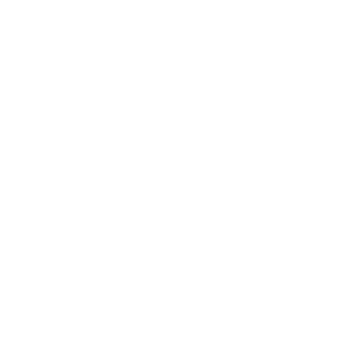

In [9]:
I, F = random.sample(test_set, 2)

IXorF = Graph(g)
label = 'label'
for u in IXorF:
    if I.nodes[u]['in'] and F.nodes[u]['in']:
        IXorF.nodes[u][label] = 'common'
    elif I.nodes[u]['in']:
        IXorF.nodes[u][label] = 'I'
    elif F.nodes[u]['in']:
        IXorF.nodes[u][label] = 'F'
    else:
        IXorF.nodes[u][label] = 'notin'
plt.figure(figsize=(10, 10))
plotSymmetricDiff(IXorF)